The following cell ensures that each notebook runs on the same dependencies and versions as all other notebooks in Google Colab / locally.

In [1]:
import os, sys, subprocess
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt

!git clone https://github.com/makinchii/CS156_Project.git /content/CS156_Project
%cd /content/CS156_Project/notebooks

def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

REQ_PATH = Path("requirements.txt")
RAW_REQ_URL = os.environ.get(
    "RAW_REQ_URL",
    "https://raw.githubusercontent.com/makinchii/CS156_Project/main/requirements.txt"
)

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.check_call(cmd)

pip = [sys.executable, "-m", "pip"]

if not in_colab() and os.environ.get("VIRTUAL_ENV") is None:
    print("Not in a virtual environment. Consider: python -m venv .venv && activate it.")

# Upgrade pip in the active kernel
run(pip + ["install", "-q", "-U", "pip"])

# Install dependencies
if REQ_PATH.exists():
    run(pip + ["install", "-q", "-r", str(REQ_PATH)])
elif in_colab() and RAW_REQ_URL:
    run(pip + ["install", "-q", "-r", RAW_REQ_URL])
else:
    print("requirements.txt not found. If you're in Colab, set RAW_REQ_URL to your repo's raw requirements.txt, e.g.:")
    print("    os.environ['RAW_REQ_URL'] = 'https://raw.githubusercontent.com/<user>/<repo>/main/requirements.txt'")

# Quick sanity print
try:
    import pandas as pd, numpy as np
    print("Python:", sys.version.split()[0])
    print("pandas:", pd.__version__)
    print("numpy :", np.__version__)
except Exception as e:
    print("(Optional) Could not import pandas/numpy for version check:", e)

fatal: destination path '/content/CS156_Project' already exists and is not an empty directory.
/content/CS156_Project/notebooks
$ /usr/bin/python3 -m pip install -q -U pip
$ /usr/bin/python3 -m pip install -q -r https://raw.githubusercontent.com/makinchii/CS156_Project/main/requirements.txt
Python: 3.12.12
pandas: 2.2.2
numpy : 2.0.2


In [2]:
# import packages
import pandas as pd
import numpy as np
sys.path.insert(0, str((pathlib.Path().resolve() / ".." / "src").resolve()))
from utils import load_dataset

In [3]:
df = load_dataset(local_rel_path="data/biosensor_dataset_with_target.csv", raw_url="https://raw.githubusercontent.com/makinchii/CS156_Project/main/data/biosensor_dataset_with_target.csv")
df.head()

Reading from RAW URL: https://raw.githubusercontent.com/makinchii/CS156_Project/main/data/biosensor_dataset_with_target.csv


,Heart_Rate,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Event_Label,Timestamp,Athlete_ID
0,166,-2.598157,2.205079,-0.649084,-48.457966,15.407057,164.550534,Accel,2025-05-11 12:14:53.417747,A001
1,159,-2.862471,2.173831,-2.054184,5.137738,34.974254,-15.283653,Jump_Takeoff,2025-05-11 12:14:53.517747,A001
2,120,-1.045441,2.755975,2.696018,-175.960480,-107.481553,177.757215,Stop,2025-05-11 12:14:53.617747,A001
3,119,2.931939,0.005220,-1.835028,-8.255970,131.909447,-172.149554,Sprint_Mid,2025-05-11 12:14:53.717747,A001
4,121,2.517730,1.217080,1.611578,-44.266911,147.303725,104.186863,Start_Run,2025-05-11 12:14:53.817747,A001


Now that we have our dataset, let's see what this data set contains. It's important to note that there is no column present for age, gender, or any other kind of demographic data.

In [4]:
# Helper methods

def get_number_of_participants(df):
    return df["Athlete_ID"].nunique()

def get_days_per_participant(df):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    dates = df.assign(Date=df["Timestamp"].dt.date)
    return dates.groupby("Athlete_ID")["Date"].nunique().sort_index()

def get_label_stats(df):
    unique_labels = df["Event_Label"].nunique()
    label_counts = df["Event_Label"].value_counts()
    return unique_labels, label_counts

def get_durations(df):
    """
    Returns a DataFrame indexed by Athlete_ID with start/end and durations.
    Durations provided in seconds, minutes, and hours.
    """
    agg = df.groupby("Athlete_ID")["Timestamp"].agg(start="min", end="max")
    delta = (agg["end"] - agg["start"]).dt.total_seconds()
    out = agg.copy()
    out["duration_seconds"] = delta
    out["duration_minutes"] = delta / 60
    out["duration_hours"] = delta / 3600
    return out

# Calculate stats

num_participants = get_number_of_participants(df)
days_per_participant = get_days_per_participant(df)
avg_days = days_per_participant.mean()
unique_labels, label_counts = get_label_stats(df)
durations = get_durations(df)

# print out stats
print(f"Number of participants: {num_participants}")
print(f"\nAverage days per participant: {avg_days:.2f}")
print(f"\nTotal unique labels: {unique_labels}")
print("\nLabels:")
print(label_counts)

print("\nRecording duration per participant (seconds):")
print(durations["duration_seconds"].round(3))

Number of participants: 5

Average days per participant: 1.00

Total unique labels: 6

Labels:
Event_Label
Start_Run       281
Stop            257
Jump_Takeoff    246
Sprint_Mid      245
Accel           241
Landing         230
Name: count, dtype: int64

Recording duration per participant (seconds):
Athlete_ID
A001    29.9
A002    29.9
A003    29.9
A004    29.9
A005    29.9
Name: duration_seconds, dtype: float64


Let's also visualize the data so that it is easier to understand.

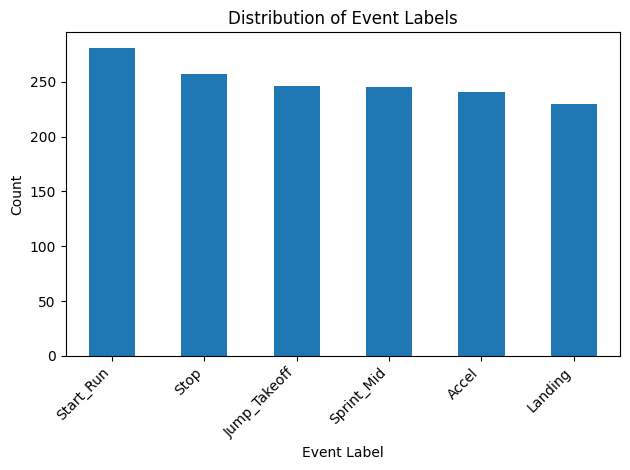

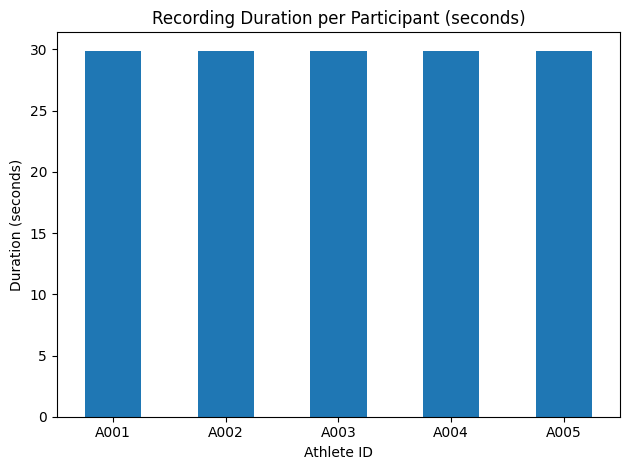

In [6]:
# 1) Label distribution
plt.figure()
label_counts.plot(kind="bar")
plt.title("Distribution of Event Labels")
plt.xlabel("Event Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) Recording duration per participant (hours)
plt.figure()
durations["duration_seconds"].plot(kind="bar")
plt.title("Recording Duration per Participant (seconds)")
plt.xlabel("Athlete ID")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()